In [1]:
import ROOT

Welcome to JupyROOT 6.10/08


In [2]:
from rootpy.plotting import set_style

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:253: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


In [3]:
set_style('ATLAS', shape='rect')

INFO:rootpy.plotting.style] using ROOT style 'ATLAS(shape=rect)'


In [4]:
path = '/Users/quentin/Desktop/Maps/RooMapsHptMMC/Comb-Boosted-SLT-All/scatterPlot_higgs_pt_lephad_mmc_mlm_mass_Ztt.root'
rfile_mc_bst_hpt_mmc = ROOT.TFile(path, 'read')
map_mc_bst_hpt_mmc = rfile_mc_bst_hpt_mmc.Get('2DMap_Hpt_MMC_Ztt')

path = '/Users/quentin/Desktop/Maps/RooMapsMjjMMC/Comb-VBF-SLT-All/scatterPlot_jets-mass_lephad_mmc_mlm_mass_Ztt.root'
rfile_mc_vbf_mjj_mmc = ROOT.TFile(path, 'read')
map_mc_vbf_mjj_mmc = rfile_mc_vbf_mjj_mmc.Get('2DMap_Mjj_MMC_Ztt')

path = '/Users/quentin/Desktop/Maps/DeltaRMaps/Comb-Boosted-SLT-All/scatterPlot_lephad_dr_lephad_mmc_mlm_mass_Ztt.root'
rfile_mc_bst_dr_mmc = ROOT.TFile(path, 'read')
map_mc_bst_dr_mmc = rfile_mc_bst_dr_mmc.Get('2DMap_dR_MMC_Ztt')

path = '/Users/quentin/Desktop/Maps/DeltaRMaps/Comb-VBF-SLT-All/scatterPlot_lephad_dr_lephad_mmc_mlm_mass_Ztt.root'
rfile_mc_vbf_dr_mmc = ROOT.TFile(path, 'read')
map_mc_vbf_dr_mmc = rfile_mc_vbf_dr_mmc.Get('2DMap_dR_MMC_Ztt')



INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpVBTo5k.png has been created


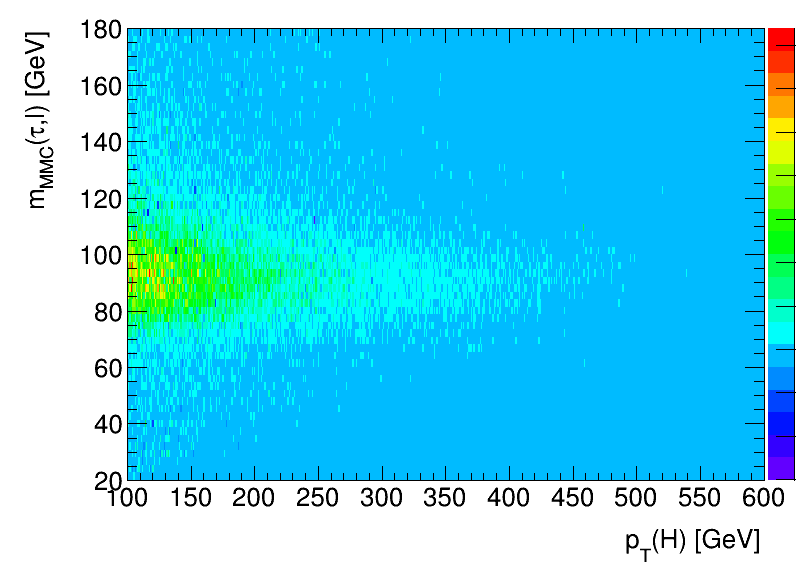

In [5]:
canv = ROOT.TCanvas()
map_mc_bst_hpt_mmc.Draw('colz')
canv

INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpYnVVam.png has been created


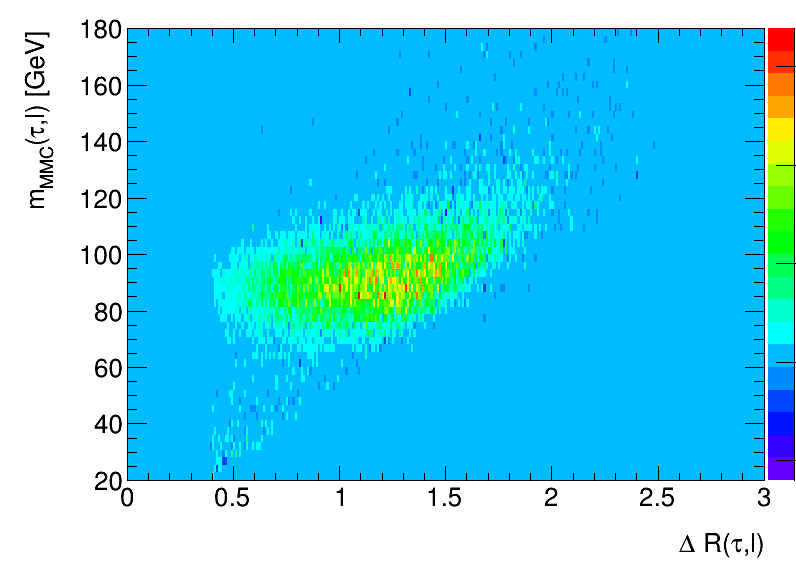

In [6]:
canv = ROOT.TCanvas()
map_mc_bst_dr_mmc.Draw('colz')
canv

INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmp056gno.png has been created


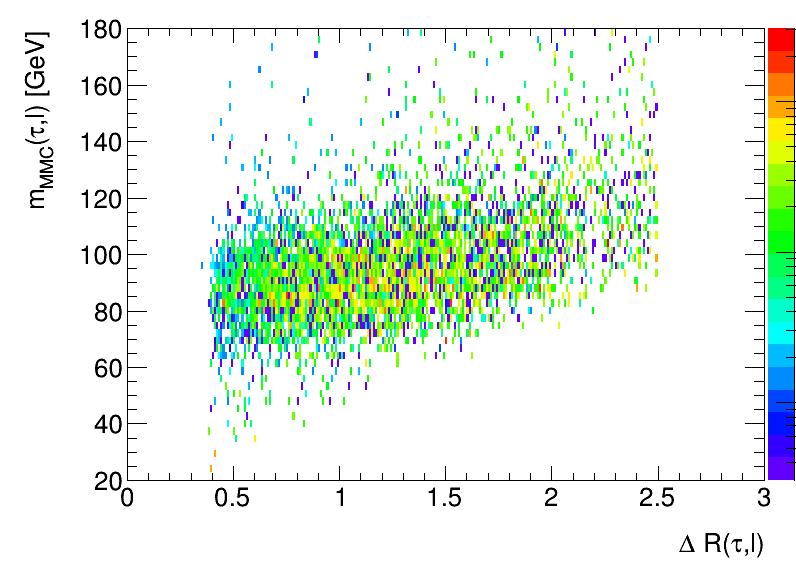

In [7]:
canv = ROOT.TCanvas()
map_mc_vbf_dr_mmc.Draw('colz')
canv.SetLogz()
canv

In [8]:

def efficiency(passed, total, passed_err, total_err):
    eff = passed / total
    pw2 = passed_err * passed_err
    tw2 = total_err * total_err
    variance = ( pw2 * (1. - 2 * eff) + tw2 * eff *eff ) / ( total * total)
    sigma = ROOT.TMath.Sqrt(ROOT.Double(variance))
    ConfLevel = 0.682689492137
    prob = 0.5 * (1 - ConfLevel)
    delta = ROOT.Math.normal_quantile_c(prob, sigma)
    return eff, delta

def cut_eff_graph(
    map_2d,
    mmc_split, 
    bin_edges, 
    xtitle='p_{T}(H) [GeV]',
    mmc_on_yaxis=True,
    color=ROOT.kBlack,
    linestyle=ROOT.kSolid,
    markerstyle=ROOT.kCircle):

    #mmc_split = 90    
    graph = ROOT.TGraphAsymmErrors(len(bin_edges) - 2)
    graph.GetYaxis().SetTitle('Efficiency of m_{MMC} < X')
    graph.GetXaxis().SetTitle(xtitle)
    graph.SetLineColor(color)
    graph.SetMarkerColor(color)
    graph.SetLineStyle(linestyle)
    graph.SetMarkerStyle(markerstyle)

    for ip, (a, b) in enumerate(zip(bin_edges[:-1],bin_edges[1:])):
        if mmc_on_yaxis:
            bin_low = map_2d.ProjectionX().FindBin(a)
            bin_high = map_2d.ProjectionX().FindBin(b)
            mmc_split_bin = map_2d.ProjectionY().FindBin(mmc_split)
            pass_err = ROOT.Double(0.)
            tot_err = ROOT.Double(0.)
            passed = map_2d.IntegralAndError(bin_low, bin_high, 1, mmc_split_bin, pass_err)
            total = map_2d.IntegralAndError(bin_low, bin_high, 1, map_2d.GetNbinsY() + 1, tot_err)
        else:
            bin_low = map_2d.ProjectionY().FindBin(a)
            bin_high = map_2d.ProjectionY().FindBin(b)
            mmc_split_bin = map_2d.ProjectionX().FindBin(mmc_split)
            pass_err = ROOT.Double(0.)
            tot_err = ROOT.Double(0.)
            passed = map_2d.IntegralAndError(1, mmc_split_bin, bin_low, bin_high, pass_err)
            total = map_2d.IntegralAndError(1, map_2d.GetNbinsX() + 1, bin_low, bin_high, tot_err)

        eff, eff_error = efficiency(passed, total, pass_err, tot_err)
        graph.SetPoint(ip, a + (b - a) / 2., eff)
        graph.SetPointError(ip, (b - a) / 2., (b - a) / 2., eff_error, eff_error)
    return graph



INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_ztt_lh_boost_pt.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_ztt_lh_boost_pt.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpWGa1s1.png has been created


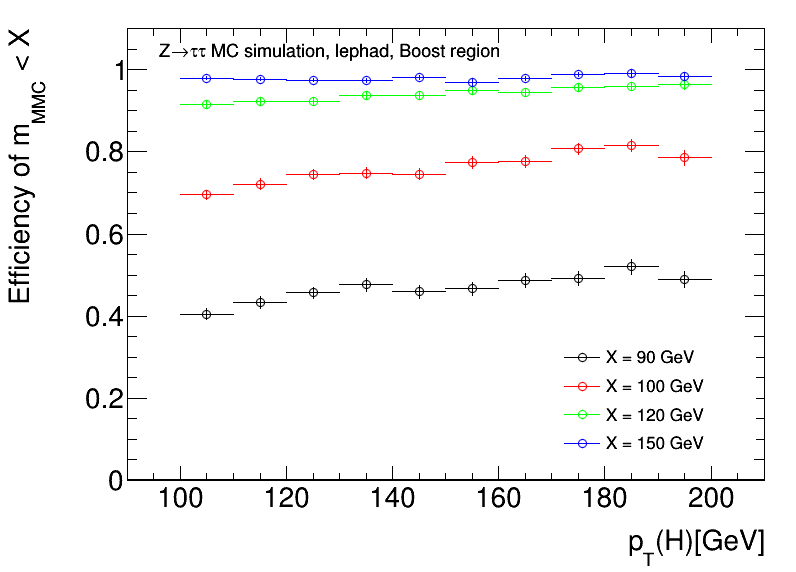

In [9]:
def mc_plot(mc_map, bin_edges, xtitle, region='Boost', leg_offset=0.):
    graphs = []
    cuts = (90, 100, 120, 150)
    colors = (1, 2, 3, 4)


    for cut, col in zip(cuts, colors):
        graphs.append(cut_eff_graph(
            mc_map, cut, bin_edges, xtitle=xtitle, color=col))

    canv = ROOT.TCanvas()
    graphs[0].GetYaxis().SetRangeUser(0., 1.1)
    graphs[0].Draw('AP')
    for gr in graphs[1:]:
        gr.Draw('sameP')
    
    leg = ROOT.TLegend(0.7 - leg_offset, 0.2, 0.95 - leg_offset, 0.4)
    for gr, cut in zip(graphs, cuts):
        leg.AddEntry(gr, 'X = {} GeV'.format(cut), 'lp')
    leg.Draw()
    label = ROOT.TLatex(0.2, 0.9, 'Z#rightarrow#tau#tau MC simulation, lephad, {} region'.format(region))
    label.SetNDC(True)
    label.SetTextSize(20)
    label.Draw()
    return canv


bin_edges = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
canv2 = mc_plot(map_mc_bst_hpt_mmc, bin_edges, 'p_{T}(H)[GeV]')
canv2.SaveAs('plots/mmc_eff_ztt_lh_boost_pt.eps')
canv2.SaveAs('plots/mmc_eff_ztt_lh_boost_pt.pdf')
canv2

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_ztt_lh_boost_dr.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_ztt_lh_boost_dr.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpUPXXiq.png has been created


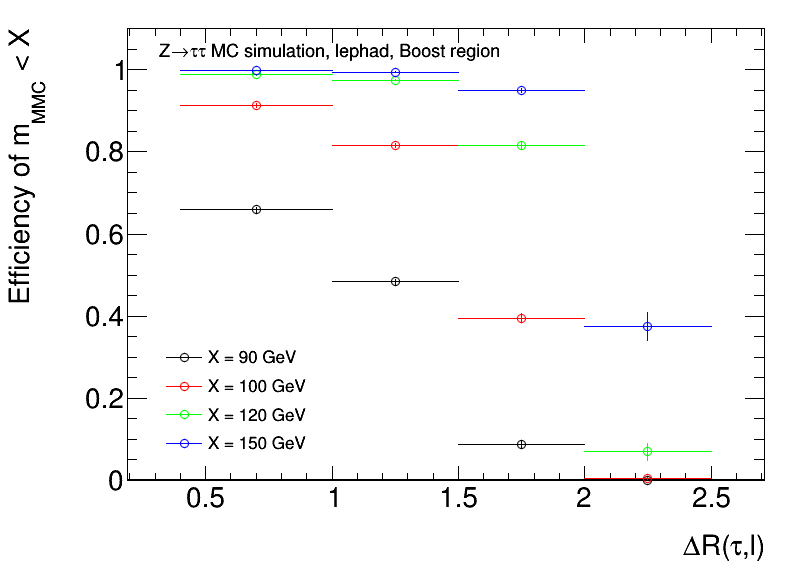

In [10]:
bin_edges = [0.4, 1., 1.5, 2.0, 2.5]
canv2 = mc_plot(map_mc_bst_dr_mmc, bin_edges, '#DeltaR(#tau,l)', leg_offset = 0.5)
canv2.SaveAs('plots/mmc_eff_ztt_lh_boost_dr.eps')
canv2.SaveAs('plots/mmc_eff_ztt_lh_boost_dr.pdf')
canv2

INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpI6OtH8.png has been created


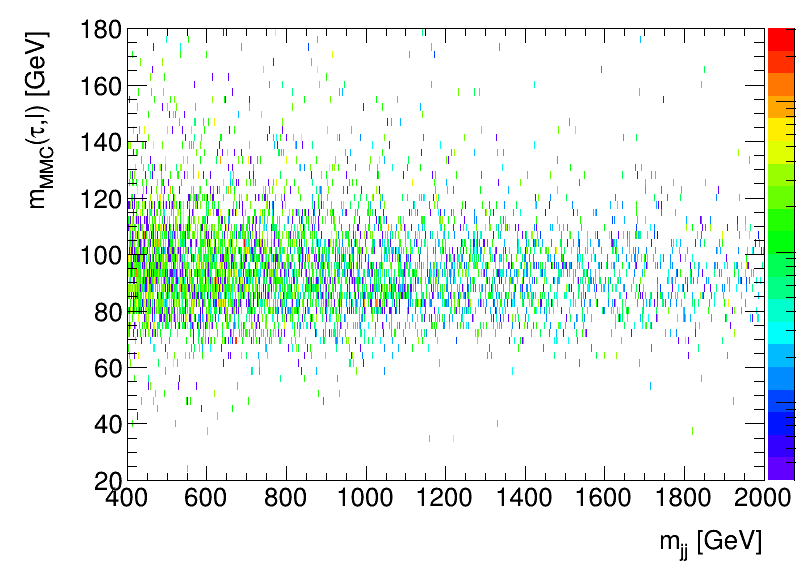

In [11]:
canv_3 = ROOT.TCanvas()
map_mc_vbf_mjj_mmc.Draw('colz')
canv_3.SetLogz()
canv_3

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_ztt_lh_vbf_mjj.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_ztt_lh_vbf_mjj.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpk_fjMk.png has been created


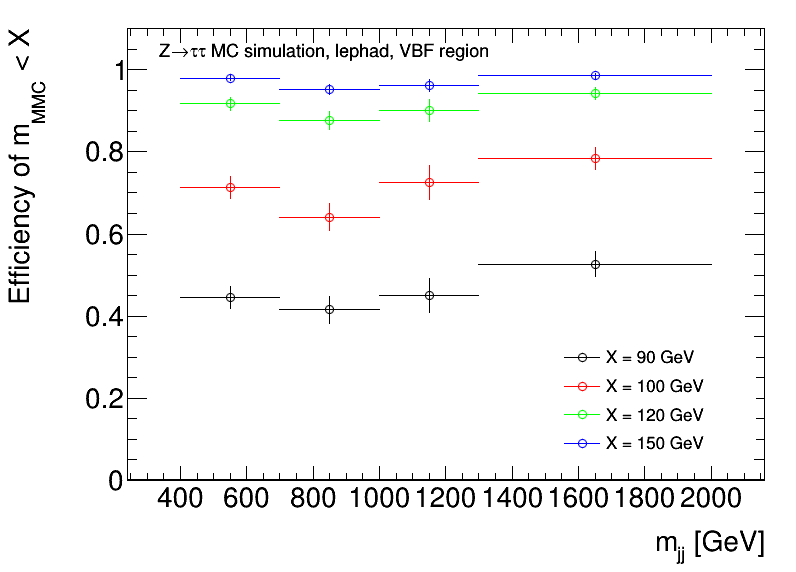

In [12]:
bin_edges = [400, 700, 1000, 1300, 2000]
graphs = []
cuts = (90, 100, 120, 150)
colors = (1, 2, 3, 4)

canv4 = mc_plot(map_mc_vbf_mjj_mmc, bin_edges, 'm_{jj} [GeV]', region='VBF')
canv4.SaveAs('plots/mmc_eff_ztt_lh_vbf_mjj.eps')
canv4.SaveAs('plots/mmc_eff_ztt_lh_vbf_mjj.pdf')
canv4



INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_ztt_lh_vbf_dr.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_ztt_lh_vbf_dr.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpXyFJAD.png has been created


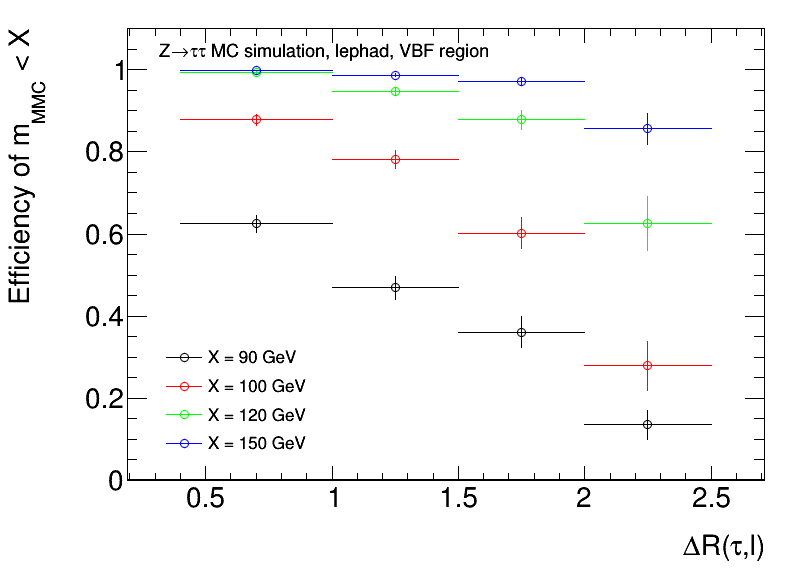

In [13]:
bin_edges = [0.4, 1., 1.5, 2.0, 2.5]
canv2 = mc_plot(map_mc_vbf_dr_mmc, bin_edges, '#DeltaR(#tau,l)', region='VBF', leg_offset=0.5)
canv2.SaveAs('plots/mmc_eff_ztt_lh_vbf_dr.eps')
canv2.SaveAs('plots/mmc_eff_ztt_lh_vbf_dr.pdf')
canv2

In [14]:
path_3 = '/Users/quentin/Downloads/forQuentin.root'
rfile_3 = ROOT.TFile(path_3, 'read')
map_da = rfile_3.Get('data_ZCRHH_VBFMMC_PtLL')
map_mc = rfile_3.Get('ZllS22_ZCRHH_VBFMMC_PtLL')

INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpfIT5VV.png has been created


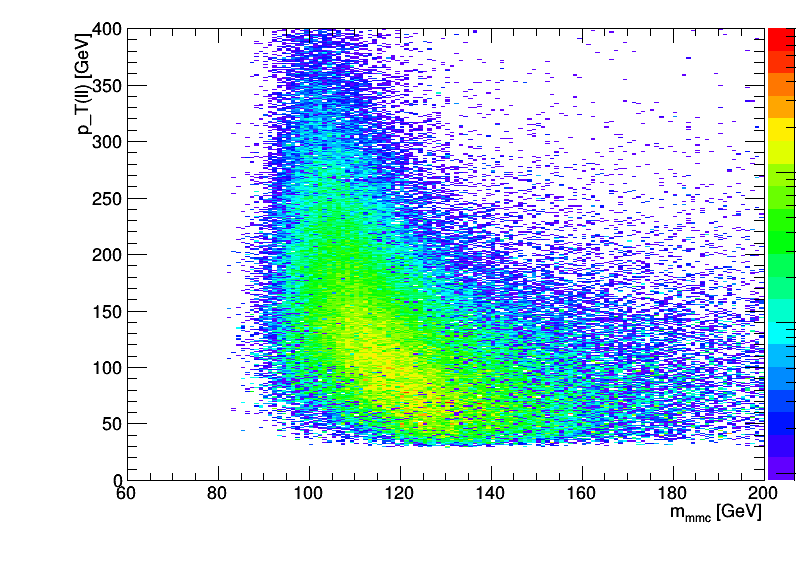

In [15]:
canv_3 = ROOT.TCanvas()
map_mc.Draw('colz')
canv_3.SetLogz()
canv_3

INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmp4MSPJo.png has been created


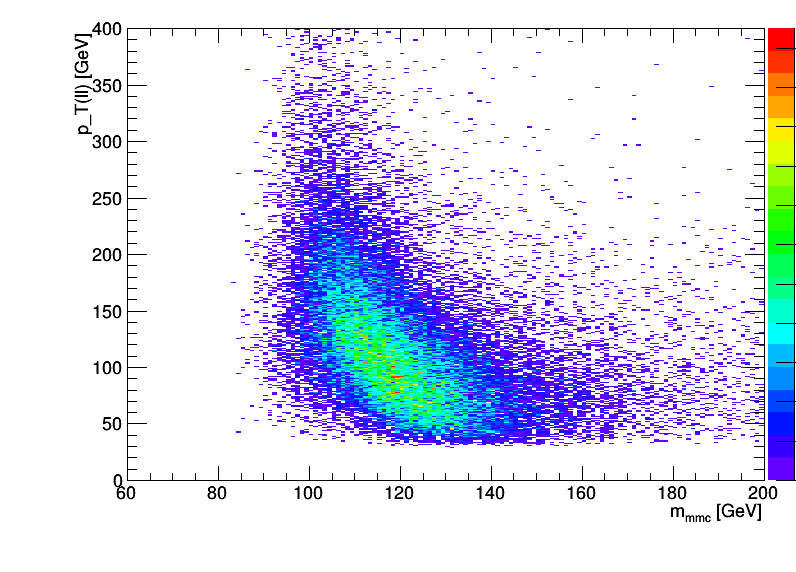

In [16]:
canv_3 = ROOT.TCanvas()
map_da.Draw('colz')
canv_3

INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpcGAOz_.png has been created


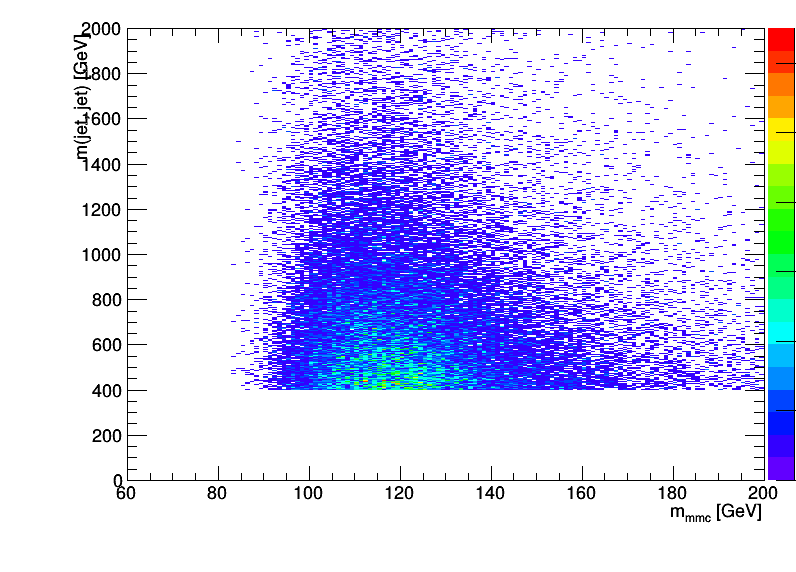

In [17]:
canv = ROOT.TCanvas()
map_da = rfile_3.Get('data_ZCRLL_VBFMMC_Mjj')
map_da.Draw('colz')
canv

INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpwogkEv.png has been created


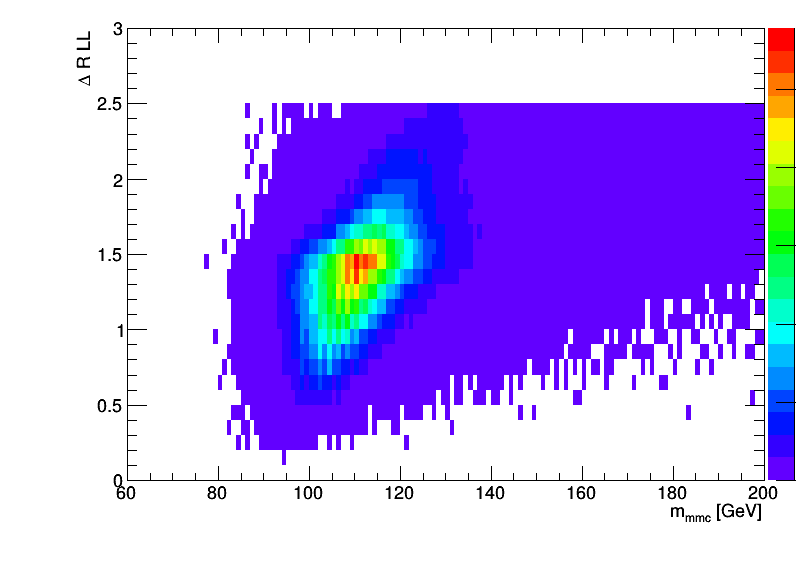

In [18]:
canv = ROOT.TCanvas()
map_da = rfile_3.Get('data_ZCRLL_BoostMMC_DRLL')
map_da.Draw('colz')
canv

INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpP5QoDx.png has been created


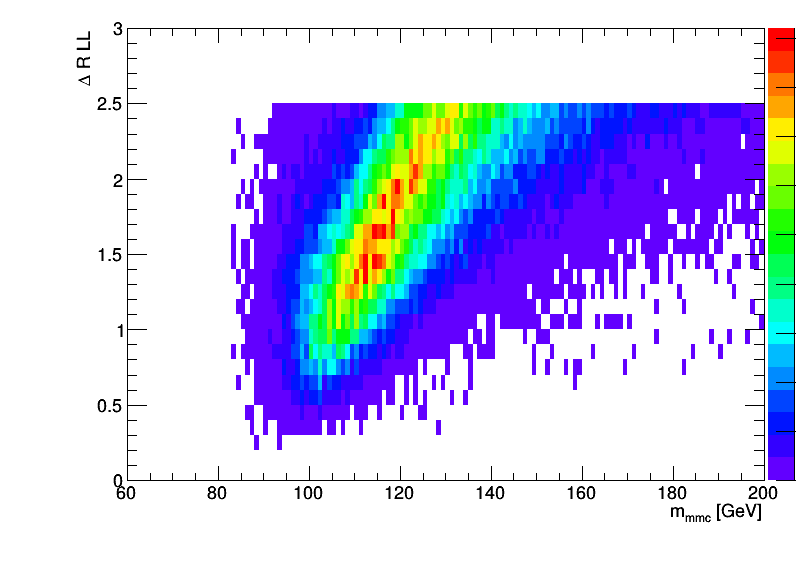

In [19]:
canv = ROOT.TCanvas()
map_da = rfile_3.Get('data_ZCRLL_VBFMMC_DRLL')
map_da.Draw('colz')
canv

In [20]:
#bin_edges = [400, 800, 2000]

def plot(map_da, map_mc, bin_edges, region, xtitle, leg_offset=0.):
    graphs_da = []
    graphs_mc = []
    cuts = (90, 100, 120, 150)
    colors = (1, 2, 3, 4)

    for cut, col in zip(cuts, colors):
        graphs_da.append(cut_eff_graph(
            map_da, cut, bin_edges, mmc_on_yaxis=False, xtitle=xtitle, color=col))
        graphs_mc.append(cut_eff_graph(
            map_mc, cut, bin_edges, mmc_on_yaxis=False, xtitle=xtitle, color=col, markerstyle=22))


    canv2 = ROOT.TCanvas()
    graphs_da[0].GetYaxis().SetRangeUser(0., 1.1)
    graphs_da[0].Draw('AP')
    for gr in graphs_da[1:]:
        gr.Draw('sameP')
    for gr in graphs_mc:
        gr.Draw('sameP')

    
    leg = ROOT.TLegend(0.7 - leg_offset, 0.25, 1.05 - leg_offset, 0.42)
    for gr, cut in zip(graphs_da, cuts):
        leg.AddEntry(gr, 'X = {} GeV'.format(cut), 'l')
    leg.Draw()

    leg_2 = ROOT.TLegend(0.7 - leg_offset, 0.4, 0.95 - leg_offset, 0.5)
    leg_2.SetNColumns(2)
    leg_2.AddEntry(graphs_da[0], 'Data', 'p')
    leg_2.AddEntry(graphs_mc[0], 'Sherpa MC', 'p')
    leg_2.SetFillStyle(0)
    leg_2.Draw()


    label = ROOT.TLatex(0.2, 0.9, 'Z#rightarrow ll events, {} inclusive region'.format(region))
    label.SetNDC(True)
    label.SetTextSize(20)
    label.Draw()
    canv2.RedrawAxis()
    return canv2


INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_lhll_vbf_ptll.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_lhll_vbf_ptll.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpHvkdiN.png has been created


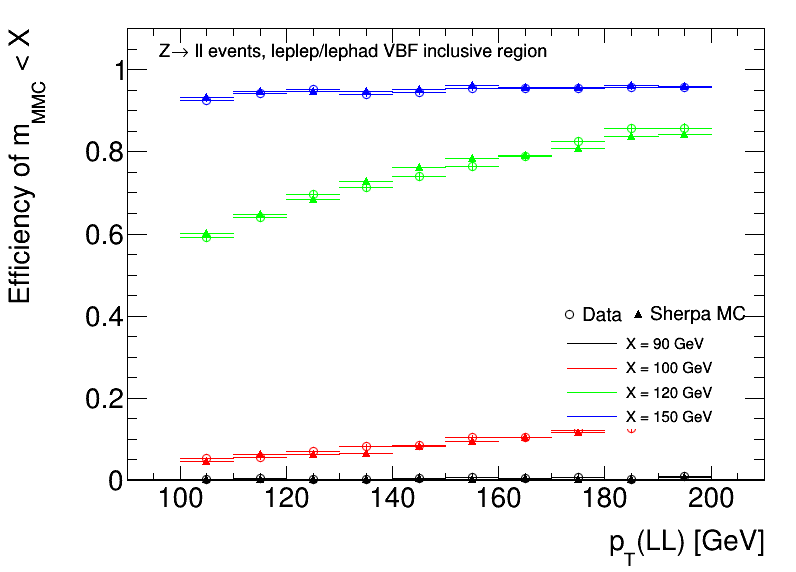

In [21]:
map_da = rfile_3.Get('data_ZCRLL_VBFMMC_PtLL')
map_mc = rfile_3.Get('ZllS22_ZCRLL_VBFMMC_PtLL')
region = 'leplep/lephad VBF'
xtitle = 'p_{T}(LL) [GeV]'
bin_edges = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

c = plot(map_da, map_mc, bin_edges, region, xtitle)
c.SaveAs('plots/mmc_eff_zll_lhll_vbf_ptll.eps')
c.SaveAs('plots/mmc_eff_zll_lhll_vbf_ptll.pdf')
c

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_lhll_vbf_mjj.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_lhll_vbf_mjj.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmp5fFTCD.png has been created


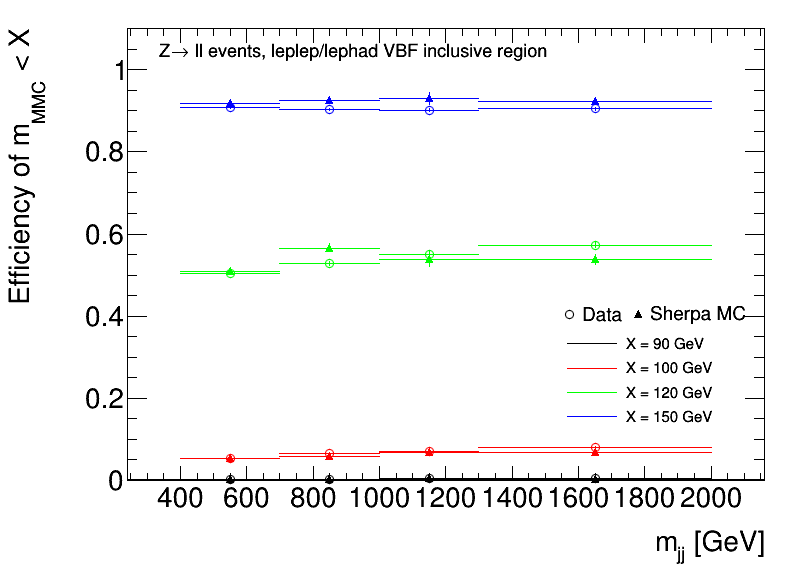

In [22]:
map_da = rfile_3.Get('data_ZCRLL_VBFMMC_Mjj')
map_mc = rfile_3.Get('ZllS22_ZCRLL_VBFMMC_Mjj')
region = 'leplep/lephad VBF'
xtitle = 'm_{jj} [GeV]'
#bin_edges = [400, 800, 1200, 1600, 2000]
bin_edges = [400, 700, 1000, 1300, 2000]
c = plot(map_da, map_mc, bin_edges, region, xtitle)
c.SaveAs('plots/mmc_eff_zll_lhll_vbf_mjj.eps')
c.SaveAs('plots/mmc_eff_zll_lhll_vbf_mjj.pdf')
c

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_lhll_vbf_drll.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_lhll_vbf_drll.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpzuF3Lt.png has been created


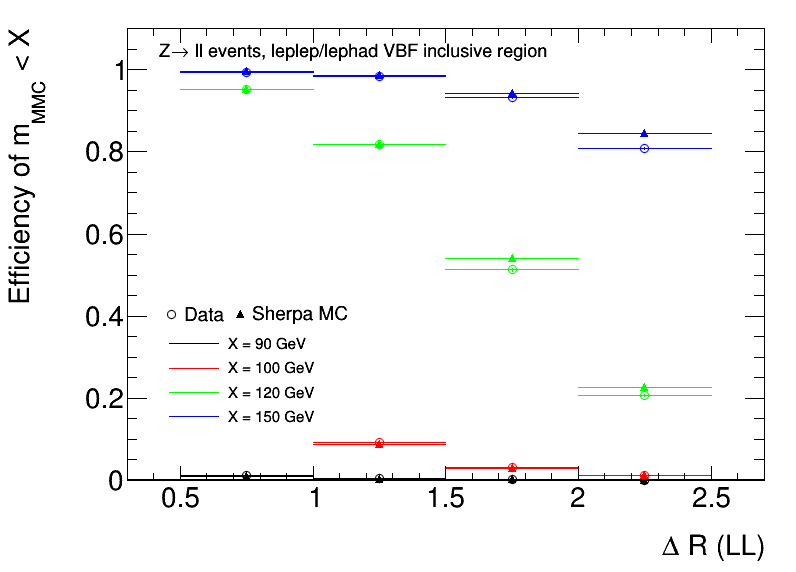

In [23]:
map_da = rfile_3.Get('data_ZCRLL_VBFMMC_DRLL')
map_mc = rfile_3.Get('ZllS22_ZCRLL_VBFMMC_DRLL')
region = 'leplep/lephad VBF'
xtitle = '#Delta R (LL)'
bin_edges = [0.5, 1., 1.5, 2.0, 2.5]

c = plot(map_da, map_mc, bin_edges, region, xtitle, leg_offset=0.5)
c.SaveAs('plots/mmc_eff_zll_lhll_vbf_drll.eps')
c.SaveAs('plots/mmc_eff_zll_lhll_vbf_drll.pdf')
c

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_lhll_boost_ptll.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_lhll_boost_ptll.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpsBAM7F.png has been created


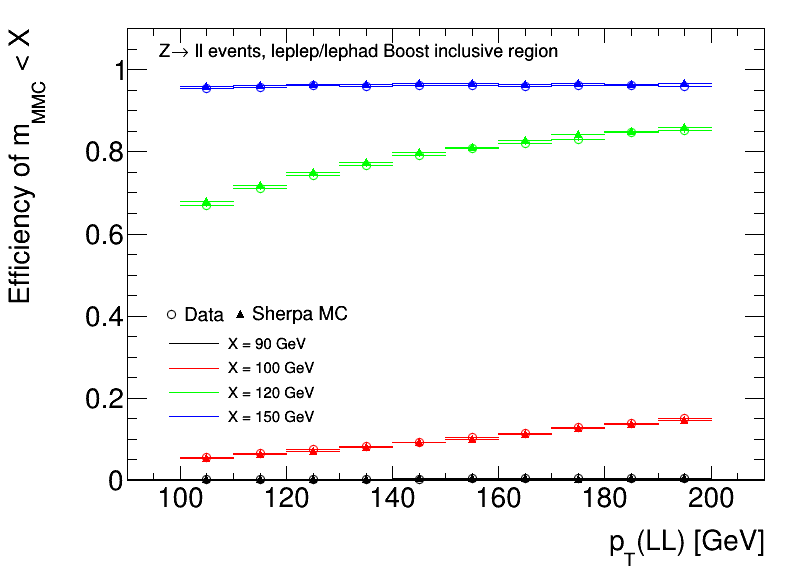

In [24]:
map_da = rfile_3.Get('data_ZCRLL_BoostMMC_PtLL')
map_mc = rfile_3.Get('ZllS22_ZCRLL_BoostMMC_PtLL')
region = 'leplep/lephad Boost'
xtitle = 'p_{T}(LL) [GeV]'
bin_edges = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

c = plot(map_da, map_mc, bin_edges, region, xtitle, leg_offset=0.5)
c.SaveAs('plots/mmc_eff_zll_lhll_boost_ptll.eps')
c.SaveAs('plots/mmc_eff_zll_lhll_boost_ptll.pdf')
c

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_lhll_boost_drll.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_lhll_boost_drll.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpRWyZvc.png has been created


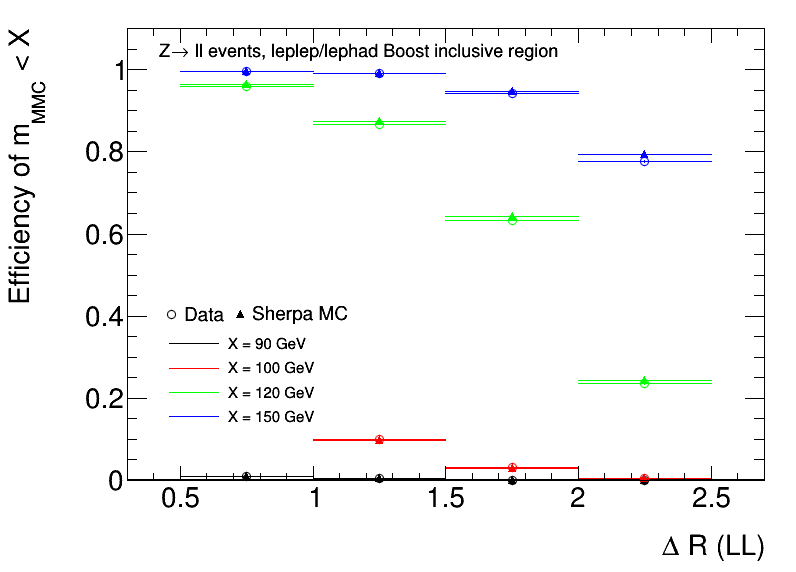

In [25]:
map_da = rfile_3.Get('data_ZCRLL_BoostMMC_DRLL')
map_mc = rfile_3.Get('ZllS22_ZCRLL_BoostMMC_DRLL')
region = 'leplep/lephad Boost'
xtitle = '#Delta R (LL)'
bin_edges = [0.5, 1., 1.5, 2.0, 2.5]

c = plot(map_da, map_mc, bin_edges, region, xtitle, leg_offset=0.5)
c.SaveAs('plots/mmc_eff_zll_lhll_boost_drll.eps')
c.SaveAs('plots/mmc_eff_zll_lhll_boost_drll.pdf')
c

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_hh_vbf_ptll.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_hh_vbf_ptll.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmp0JtSDw.png has been created


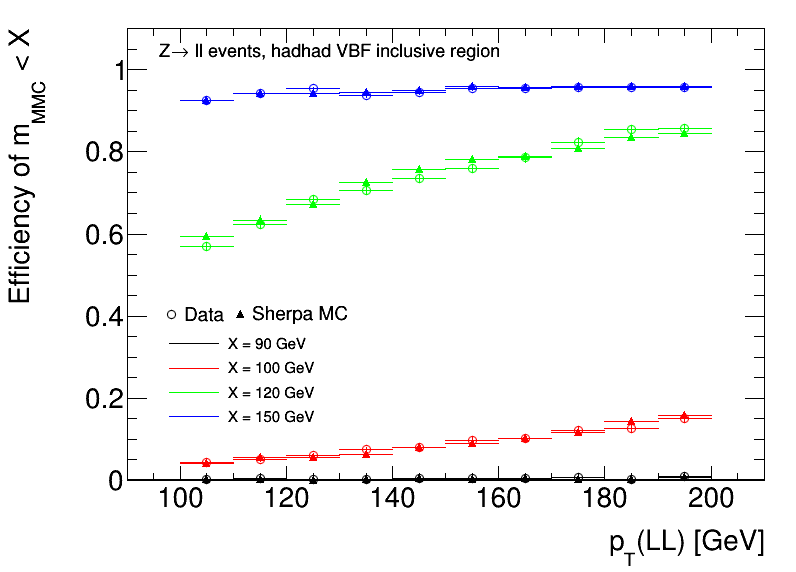

In [26]:
map_da = rfile_3.Get('data_ZCRHH_VBFMMC_PtLL')
map_mc = rfile_3.Get('ZllS22_ZCRHH_VBFMMC_PtLL')
region = 'hadhad VBF'
xtitle = 'p_{T}(LL) [GeV]'
bin_edges = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

c = plot(map_da, map_mc, bin_edges, region, xtitle, leg_offset=0.5)
c.SaveAs('plots/mmc_eff_zll_hh_vbf_ptll.eps')
c.SaveAs('plots/mmc_eff_zll_hh_vbf_ptll.pdf')
c

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_hh_vbf_mjj.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_hh_vbf_mjj.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpbGGgTT.png has been created


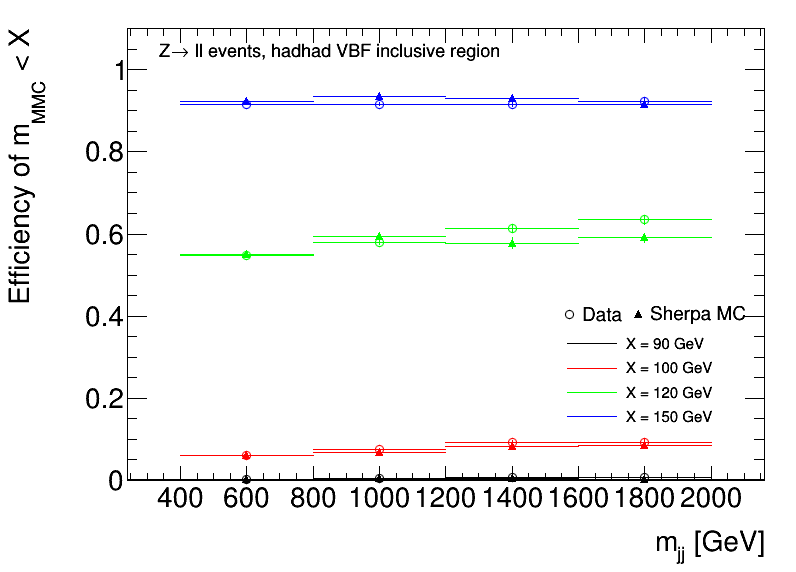

In [27]:
map_da = rfile_3.Get('data_ZCRHH_VBFMMC_Mjj')
map_mc = rfile_3.Get('ZllS22_ZCRHH_VBFMMC_Mjj')
region = 'hadhad VBF'
xtitle = 'm_{jj} [GeV]'
bin_edges = [400, 800, 1200, 1600, 2000]

c = plot(map_da, map_mc, bin_edges, region, xtitle)
c.SaveAs('plots/mmc_eff_zll_hh_vbf_mjj.eps')
c.SaveAs('plots/mmc_eff_zll_hh_vbf_mjj.pdf')
c

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_hh_vbf_drll.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_hh_vbf_drll.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmp2bbV7i.png has been created


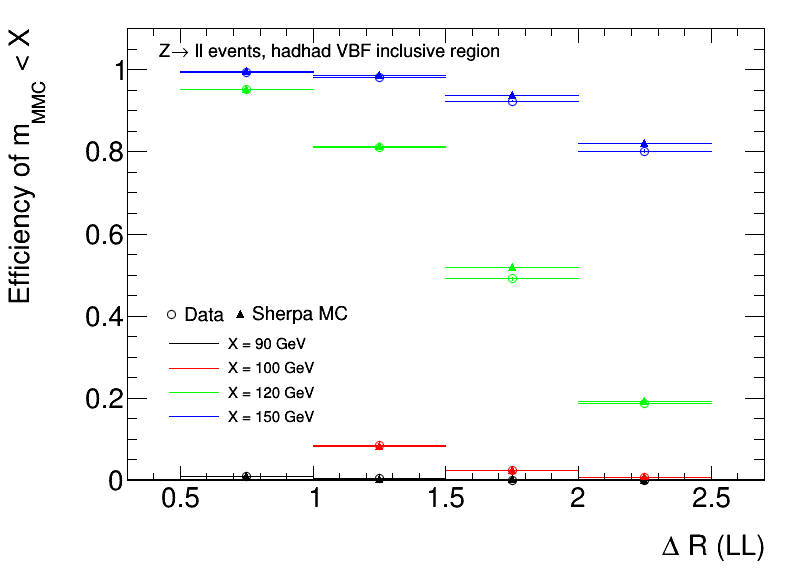

In [28]:
map_da = rfile_3.Get('data_ZCRHH_VBFMMC_DRLL')
map_mc = rfile_3.Get('ZllS22_ZCRHH_VBFMMC_DRLL')
region = 'hadhad VBF'
xtitle = '#Delta R (LL)'
bin_edges = [0.5, 1., 1.5, 2, 2.5]

c = plot(map_da, map_mc, bin_edges, region, xtitle, leg_offset=0.5)
c.SaveAs('plots/mmc_eff_zll_hh_vbf_drll.eps')
c.SaveAs('plots/mmc_eff_zll_hh_vbf_drll.pdf')
c

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_hh_boost_ptll.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_hh_boost_ptll.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpR5PT77.png has been created


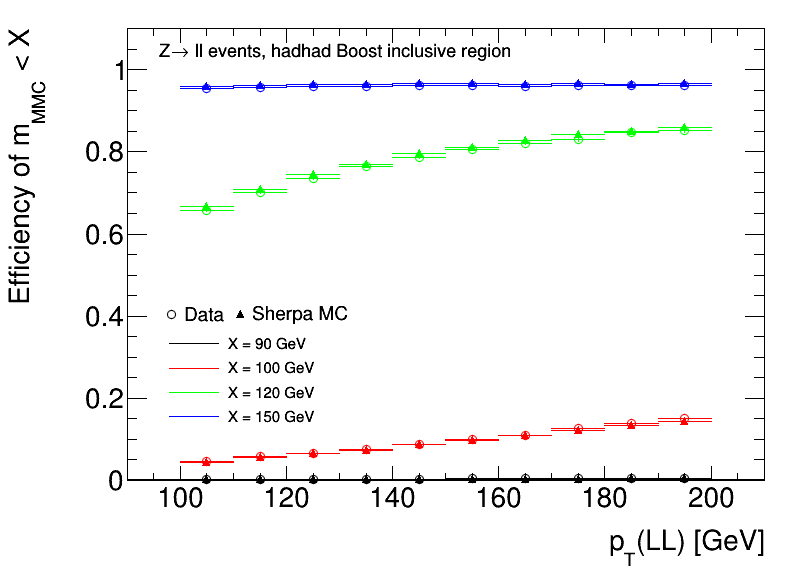

In [29]:
map_da = rfile_3.Get('data_ZCRHH_BoostMMC_PtLL')
map_mc = rfile_3.Get('ZllS22_ZCRHH_BoostMMC_PtLL')
region = 'hadhad Boost'
xtitle = 'p_{T}(LL) [GeV]'
bin_edges = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

c = plot(map_da, map_mc, bin_edges, region, xtitle, leg_offset=0.5)
c.SaveAs('plots/mmc_eff_zll_hh_boost_ptll.eps')
c.SaveAs('plots/mmc_eff_zll_hh_boost_ptll.pdf')
c

INFO:ROOT.TCanvas.Print] eps file plots/mmc_eff_zll_hh_boost_drll.eps has been created
INFO:ROOT.TCanvas.Print] pdf file plots/mmc_eff_zll_hh_boost_drll.pdf has been created
INFO:ROOT.TCanvas.Print] png file /var/folders/yf/43k_1b814y3d2yx1rqlfxr5c0000gn/T/tmpWdWgdG.png has been created


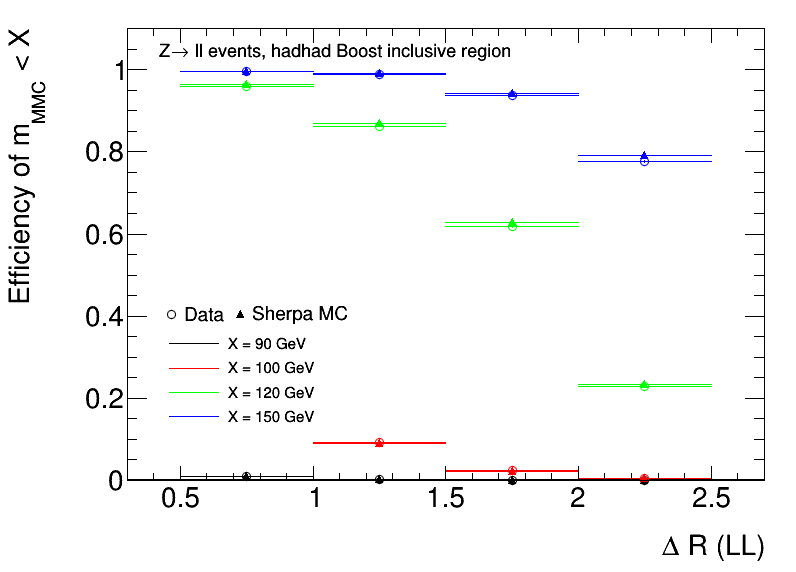

In [30]:
map_da = rfile_3.Get('data_ZCRHH_BoostMMC_DRLL')
map_mc = rfile_3.Get('ZllS22_ZCRHH_BoostMMC_DRLL')
region = 'hadhad Boost'
xtitle = '#Delta R (LL)'
bin_edges = [0.5, 1., 1.5, 2, 2.5]

c = plot(map_da, map_mc, bin_edges, region, xtitle, leg_offset=0.5)
c.SaveAs('plots/mmc_eff_zll_hh_boost_drll.eps')
c.SaveAs('plots/mmc_eff_zll_hh_boost_drll.pdf')
c